# USA Water Systems and Operators

## References

## Imports and Setup

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Data

In [27]:
folder_WaterSystems = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\watersystems"
csv_FacilityFiles = "C:\\Users\\garfink2\\Documents\\data\\drinkingwater\\national_combined\\NATIONAL_FACILITY_FILE.CSV"
shp_USCounties = "C:\\Users\\garfink2\\Documents\\data\\basemap\\tl_2017_us_county\\tl_2017_us_county.shp"

## Analyses

### Water Treatment Systems

In [6]:
list_StateFiles = os.listdir(folder_WaterSystems)

In [12]:
dict_StateFiles = {}
for stateFile in list_StateFiles:
    df = pd.read_csv(f"{folder_WaterSystems}/{stateFile}",encoding='cp1252')
    df["State"] = stateFile.split('.')[0].upper()
    dict_StateFiles[stateFile.split('.')[0].upper()] = df

In [18]:
df["Counties Served"]

0      Fremont
1      Lincoln
2      Natrona
3      Laramie
4      Natrona
        ...   
773       Park
774       Park
775       Park
776       Park
777    Johnson
Name: Counties Served, Length: 778, dtype: object

In [20]:
for i,row in df.iterrows():
    if "," in row["Counties Served"]:
        print(row)

PWS ID                                          WY5601140
PWS Name                  BLM FONTENELLE CREEK CAMPGROUND
PWS Type                   Transient non-community system
Primary Source                               Ground water
Counties Served                       Lincoln, Sweetwater
Cities Served                                ROCK SPRINGS
PopulationServed Count                                 25
Number of Facilities                                    7
Number of Violations                                    6
Number of Site Visits                                   7
State                                                  WY
Name: 453, dtype: object
PWS ID                                         WY5600688
PWS Name                           MEADOWLARK LAKE LODGE
PWS Type                  Transient non-community system
Primary Source                              Ground water
Counties Served                       Big Horn, Washakie
Cities Served                                    WOR

In [31]:
df_AllStateWaterSupplies = pd.concat(list(dict_StateFiles.values()))

### National Facilities

In [22]:
nationalFacilities = pd.read_csv(csv_FacilityFiles)

C:\Users\garfink2\AppData\Local\Continuum\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4,7,11,12,13,14,15,16,21,23,24,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
nationalFacilities.head()

,FRS_FACILITY_DETAIL_REPORT_URL,REGISTRY_ID,PRIMARY_NAME,LOCATION_ADDRESS,SUPPLEMENTAL_LOCATION,CITY_NAME,COUNTY_NAME,FIPS_CODE,STATE_CODE,STATE_NAME,...,US_MEXICO_BORDER_IND,PGM_SYS_ACRNMS,LATITUDE83,LONGITUDE83,CONVEYOR,COLLECT_DESC,ACCURACY_VALUE,REF_POINT_DESC,HDATUM_DESC,SOURCE_DESC
0,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491735,OCEAN DOCK TERMINAL AND ANCHORAGE TERMINAL II,1076 OCEAN DOCK RD,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,...,NaN,"AIR:AK0000000202000032, AIRS/AFS:0202000032, B...",61.229579,-149.893094,EPA_SLT,INTERPOLATION-PHOTO,125.0,FACILITY CENTROID,NAD83,NaN
1,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491744,INLET PERTROLEUM ANCHORAGE,459 W BLUFF DR,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,...,NaN,"EIS:677611, ICIS:2600029860, ICIS:5870869, NPD...",61.231236,-149.888143,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
2,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491762,UNIVAR USA,590 E 100TH AVE,NaN,ANCHORAGE,ANCHORAGE,02020,AK,ALASKA,...,NaN,"AIR:AK0000000202000105, BR:AKD981765902, EIS:6...",61.129407,-149.871824,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
3,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491780,FAIRBANKS PETROLEUM TERMINAL,5500 AIRPORT INDUSTRIAL RD,NaN,FAIRBANKS,FAIRBANKS NORTH STAR,02090,AK,ALASKA,...,NaN,"EIS:680011, ICIS:600007563, NPDES:AKR06AB58, N...",64.811292,-147.884914,EPA_SLT,INTERPOLATION-PHOTO,3.0,FACILITY CENTROID,NAD83,NaN
4,http://ofmpub.epa.gov/enviro/fii_query_detail....,110000491824,TESORO ALASKA KETCHIKAN TERMINAL,1010 STEDMAN ST,NaN,KETCHIKAN,KETCHIKAN GATEWAY,02130,AK,ALASKA,...,NaN,"EIS:540611, NPDES:AK0000523, RCRAINFO:AKD09983...",55.335010,-131.627950,FRS-TRIS,ADDRESS MATCHING-HOUSE NUMBER,30.0,CENTER OF A FACILITY OR STATION,NAD83,NaN


In [24]:
nationalFacilities.columns

Index(['FRS_FACILITY_DETAIL_REPORT_URL', 'REGISTRY_ID', 'PRIMARY_NAME',
       'LOCATION_ADDRESS', 'SUPPLEMENTAL_LOCATION', 'CITY_NAME', 'COUNTY_NAME',
       'FIPS_CODE', 'STATE_CODE', 'STATE_NAME', 'COUNTRY_NAME', 'POSTAL_CODE',
       'FEDERAL_FACILITY_CODE', 'FEDERAL_AGENCY_NAME', 'TRIBAL_LAND_CODE',
       'TRIBAL_LAND_NAME', 'CONGRESSIONAL_DIST_NUM', 'CENSUS_BLOCK_CODE',
       'HUC_CODE', 'EPA_REGION_CODE', 'SITE_TYPE_NAME', 'LOCATION_DESCRIPTION',
       'CREATE_DATE', 'UPDATE_DATE', 'US_MEXICO_BORDER_IND', 'PGM_SYS_ACRNMS',
       'LATITUDE83', 'LONGITUDE83', 'CONVEYOR', 'COLLECT_DESC',
       'ACCURACY_VALUE', 'REF_POINT_DESC', 'HDATUM_DESC', 'SOURCE_DESC'],
      dtype='object')

In [25]:
nationalFacilities["FRS_FACILITY_DETAIL_REPORT_URL"][1]

'http://ofmpub.epa.gov/enviro/fii_query_detail.disp_program_facility?p_registry_id=110000491744'

In [26]:
nationalFacilities["HUC_CODE"]

0          19020401.0
1          19020401.0
2          19020401.0
3          19040506.0
4          19010102.0
              ...    
4224068           NaN
4224069           NaN
4224070           NaN
4224071           NaN
4224072           NaN
Name: HUC_CODE, Length: 4224073, dtype: float64

### Basemap Data

In [28]:
gdf_USCounties = gpd.read_file(shp_USCounties)

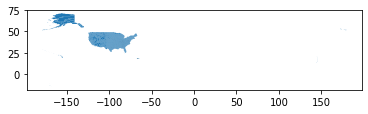

In [29]:
gdf_USCounties.plot()

In [30]:
gdf_USCounties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-96.91060 40.95841, -96.91060 40.958..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


### Map water systems to US counties

In [ ]:
for k,v in 